# RICH SNR (Signal-Noise Ratio) depending on DCR

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
# DCR, Crosstalk, Afterpulsing pixel model
def Pixel (DCR, Pixel_size, Cross, After, W): # DCR(Hz/mm2), pixel size(mm2), Crosstalk(%), Afterpulsing(%), recording window(ns)

    # Pulse shape
    
    Cj = 20e-12
    Rs = 10
    RQ = 50

    t_pulse = np.linspace(0,10,10)*1e-9
    N = len(t_pulse)
    Pulse = np.zeros(N)

    A = 1.1
    t1 = 1e-9

    for i in range (N):
        if t_pulse[i] < t1:
            Pulse[i] = A*(1-np.exp(-t_pulse[i]/(Rs*Cj)))
        else:
            Pulse[i] = A*np.exp((t1-t_pulse[i])/(RQ*Cj))
        
    DCR_pixel = DCR*Pixel_size
    Tau = 1/DCR_pixel
    F_after = After*DCR_pixel
    Tau_after = 1/F_after

    # Adding afterpulsing

    DCR_impulses = np.zeros(W)
    Cross_impulses = np.zeros(W)
    After_impulses = np.zeros(W)
    DCR_Cross_After_pulses = np.zeros(W)
    index = 0

    while index < W-N:
        Rt = np.random.exponential(scale=Tau, size=None)*1e9
        index = index + int(Rt)
        if index >= W-N:
            break
            
        if np.random.uniform() < Cross: # Crosstalk probability
            Cross_impulses[index] = 2
            DCR_Cross_After_pulses[index:index+N] = DCR_Cross_After_pulses[index:index+N] + 2*Pulse

        else:
            DCR_impulses[index] = 1
            DCR_Cross_After_pulses[index:index+N] = DCR_Cross_After_pulses[index:index+N] + Pulse

        if np.random.uniform() < After: # Afterpulse probability
            Rt_after = int(np.random.exponential(scale=Tau_after, size=None)*1e9)

            if index+Rt_after > W-N:
                break
            After_impulses[index+Rt_after] = 1
            DCR_Cross_After_pulses[index+Rt_after:index+Rt_after+N] = DCR_Cross_After_pulses[index+Rt_after:index+Rt_after+N] + Pulse

        
    return DCR_Cross_After_pulses

In [3]:
def Noise(DCR, Pixel_size, Cross, After, W, T0, Window, M, N_pixel, P):
    Noise_array = np.zeros((Nr*8,Nc*8))

    C = 0
    F = 0

    for j in range(P):
        for i in range(N_pixel):
            Array_i[i,:] = Pixel(DCR, Pixel_size, Cross, After, W)

        MPPC_i = np.zeros(N_pixel) 

        for i in range(N_pixel):
            if np.max(Array_i[i,T0:T0+Window]) >= Trigger:
                MPPC_i[i] = 1
        MPPC = np.reshape(MPPC_i, (M, M))
        Noise_array[F*8+0:F*8+8,C*8+0:C*8+8] = MPPC 
        C+=1
        if C==P/Nr:
            C=0
            F+=1
            
    return Noise_array

In [4]:
def Ring(Nr,Nc, r, Np_ring):
    
    Ring_array = np.zeros((Nr*8,Nc*8))

    x0 = int(np.random.uniform(0, Nr*8))
    y0 = int(np.random.uniform(0, Nc*8))

    for i in range(Np_ring):

        theta = np.random.uniform(0, 2*np.pi)

        x = int(r*np.cos(theta))
        y = int(r*np.sin(theta))
        a = x + x0
        b = y + y0

        if a >= 0 and b >=0 and a < Nr*8 and b < Nc*8: # boundary conditions
            Ring_array[a,b]= Ring_array[a,b] + 1
            
    return Ring_array

## MPPC model

In [5]:
M = 8 # M x M array szie
N_pixel = M*M

Pixel_size = 36 # mm2
Cross = 0.25 # %
After = 0.05 # %
W = 100 # Recording window

T0 = 45 # Detection time
Window = 5

Trigger = 0.5 # Trigger level

In [22]:
DCR = np.linspace(1,300,300)*1e3 # DCR values Hz/mm2
SNR_mean = np.zeros(len(DCR))
SNR_std = np.zeros(len(DCR))

Array_i = np.zeros((N_pixel,W))
Nr = 2  # Number rows
Nc = 3  # Number of columns
P = Nr*Nc # Number of MPPC

r  = 6 # Cherenkov ring diameter, we can add radious variance
Np_ring = 20 # Number of photons per ring  
    
samples = 100 # samples per DCR value


for i in range(len(DCR)):
    SNR = np.zeros(samples)
    
    for j in range(samples):
        
        # Noise generation

        Noise_array = Noise(DCR[i], Pixel_size, Cross, After, W, T0, Window, M, N_pixel, P)

        # Ring generation

        Ring_array = Ring(Nr,Nc,r,Np_ring)

        SNR[j] = 20*np.log10(np.sum(Ring_array)/np.sum(Noise_array))
        
    SNR_mean[i] = np.mean(SNR)
    SNR_std[i] = np.std(SNR)

/tmp/ipykernel_1524/668964908.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  SNR[j] = 20*np.log10(np.sum(Ring_array)/np.sum(Noise_array))
/tmp/ipykernel_1524/668964908.py:29: RuntimeWarning: divide by zero encountered in log10
  SNR[j] = 20*np.log10(np.sum(Ring_array)/np.sum(Noise_array))


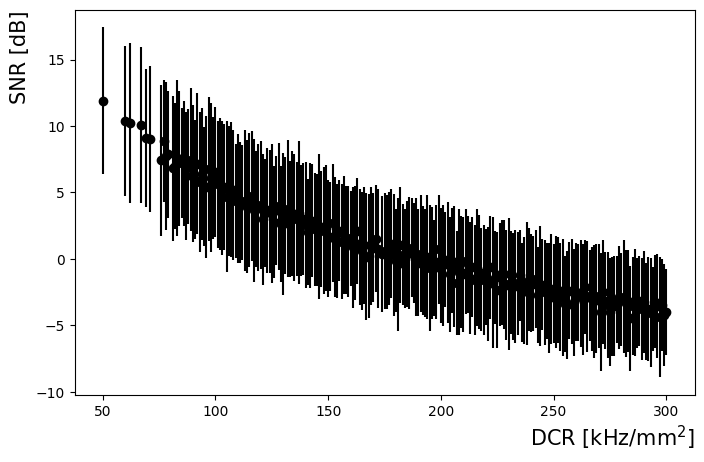

In [29]:
plt.figure(figsize=(8, 5))
plt.errorbar(DCR/1e3, SNR_mean, xerr=None, yerr=SNR_std,  fmt='o', color='k')
plt.xlabel("DCR [kHz/mm$^2$]", horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel("SNR [dB]", horizontalalignment='right', y=1.0, fontsize=15)

#plt.savefig("Figures/SNR_20_Fine.eps",bbox_inches='tight')